In [1]:
import matplotlib.pyplot as plt
import shap
from matplotlib import pyplot
import math
import pickle
import numpy as np

In [2]:
def predict_weighted_average(models,X):
    
    # initializing lists that we will need later
    y_pred = []
    y_pred_prob = []
    y_pred_models = []
    y_pred_models1 = []
    aver=[]
    # count the number of models
    models_size = len(models)
    
    # count the number of patients we want to predict their probability of cvd, in our case it will be always 1
    X_size = len(X)
    # initialiazing the weights
    weights = [0.2, 0.15, 0.15, 0.1, 0.15, 0.25]
    
    # y_pred_models gives the output of each model as marginal output, it will bw need for shap
    # y_pred_models1 gives the output of each model as probabilities
    for i in range(models_size):
        y_pred_models.append(models[i].predict(X,output_margin=True))  
        y_pred_models1.append(models[i].predict_proba(X)[:,1])
    
    total_shap_values = []
    total_expected_value = 0
    
    for i in range(models_size):
        # for each model we create a shap explainer
        explainer = shap.TreeExplainer(models[i],feature_perturbation = "tree_path_dependent")
        
        #  using the explainer we calculate the shapley values of each feature
        shap_values = explainer.shap_values(X)
        # we multiply the shapley values with the weight that correspond with the current model
        shap_values_weights = [[l*weights[i] for l in k] for k in shap_values]
        
        if(i==0):
             total_shap_values = shap_values_weights.copy()
        else:
            # we add the weighted shapley values of all models together
            for a in range(len(total_shap_values)):
                for b in range(len(total_shap_values[0])):
                     total_shap_values[a][b] += shap_values_weights[a][b]
        # we add together the expected value of each model
        total_expected_value += explainer.expected_value*weights[i] 
 
    t_shap_values = np.array(total_shap_values)
    
       
    for j in range(X_size):
        
        # here we perform the weighted voting
        sum = 0
        for i in range(models_size):
            sum = sum + y_pred_models[i][j]*weights[i]
        avr = sum  

        aver.append(avr)

        pred_prob = math.exp(avr)/(1 + math.exp(avr))
        y_pred_prob.append(pred_prob)
        
        if pred_prob>= 0.5:
            y_pred.append(1.)
        else:
            y_pred.append(0.)
  
            
    return y_pred,t_shap_values,y_pred_prob, total_expected_value

In [3]:
from sklearn.metrics import  confusion_matrix,roc_curve, roc_auc_score, accuracy_score
from sklearn import metrics
from sklearn.metrics import brier_score_loss
from statistics import mean,pstdev
import warnings
warnings.filterwarnings('ignore')

def my_cross_val(X_test_external):
  
    # initializing lists that we will need later
    shap_values = []
    y_pred_total = []
    y_pred_prob_total = []
    cv_expected_value = 0

    
    # load lodel
    filename = 'finalized_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))   

    # list of features' names 
    feature_names = ['Age','Diabetes duration','BMI','Parental History of Diabetes','Smoking Habit','Lipid-lowering therapy','Aspirin','Pulse Pressure','Glycosylated Hemoglobin','Fasting Glucose','Total Cholesterol','Triglycerides','HDL Cholesterol']

    # we convert the imput list with all features in array, the features must be added with the order that have
    # feature_names list
    X_test_external = np.array(X_test_external)
    
    # y_pred = the prediction in binary mode (1 or 0)
    # y_pred_prob = the prediction in percentage
    # shap_values = an array with the shap values of each feature
    # total_expected_value = the shap value before we add the shap_values, so the shap values 
    # without the contribution of shap_values
    y_pred,shap_values,y_pred_prob, total_expected_value = predict_weighted_average(loaded_model,X_test_external)
    
    # printing decision_plot
    shap.decision_plot(total_expected_value, shap_values[0,:], feature_names, link='logit',show=False)
    plt1 = plt.savefig('decision_plot.png', bbox_inches='tight')

    plt.show()

    # printing force_plot
    shap.force_plot(total_expected_value, shap_values[0,:], X_test_external[0,:],feature_names,show=False,matplotlib=True,link='logit')
    plt2 = plt.savefig('force_plot.png', bbox_inches='tight')
    plt.show()

    
    return y_pred_prob[0], plt1, plt2

In [4]:
X_test_external = [[ 71.  ,  18.   , 19.78  , 1.   ,  1.   ,  1.    , 1.    ,55.   ,  6.6   ,90.,
  153.   , 71.  ,  50.  ]]

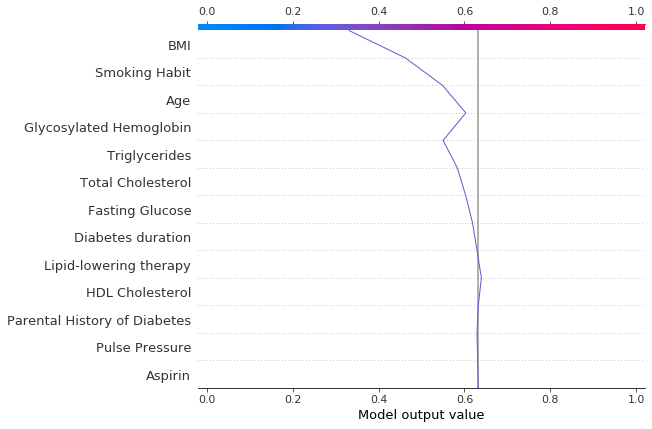

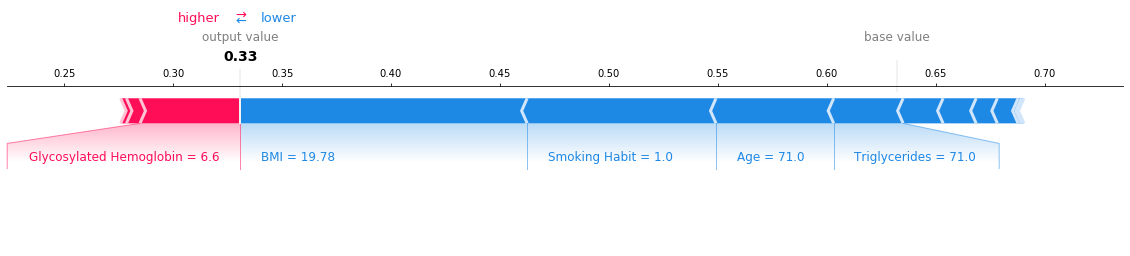

In [5]:
prediction, plt1, plt2 = my_cross_val(X_test_external)
